In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np


In [3]:
dataset = pd.read_csv('online_course_engagement_data.csv')
dataset.drop('UserID', axis = 1, inplace=True)
dataset.drop_duplicates(inplace=True)

predictors = list(set(dataset.columns) - set(['CourseCompletion']))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, predictors], dataset.loc[:, 'CourseCompletion'],  train_size=0.8, random_state=42, stratify=dataset['CourseCompletion'])

<h2>Preprocessing - scaling and one-hot encoding</h2>

In [5]:
course_category_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

course_category_OH = course_category_enc.fit_transform(X_train[['CourseCategory']])

course_category_OH = pd.DataFrame(course_category_OH, columns=course_category_enc.get_feature_names_out())
course_category_OH.index = X_train.index

X_train.drop('CourseCategory', axis=1, inplace=True)
X_train = pd.concat([X_train, course_category_OH], axis=1)

In [6]:
cols_for_scaling = ['CompletionRate', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'TimeSpentOnCourse', 'QuizScores']

In [7]:
sc = StandardScaler()
scaled_columns = sc.fit_transform(X_train[cols_for_scaling])
X_train[cols_for_scaling] = scaled_columns

In [8]:
course_cat_test_OH = course_category_enc.transform(X_test[['CourseCategory']])
course_cat_test_OH_df = pd.DataFrame(course_cat_test_OH, columns=course_category_enc.get_feature_names_out())
course_cat_test_OH_df.index = X_test.index
X_test.drop('CourseCategory', axis=1, inplace=True)
X_test = pd.concat([X_test, course_cat_test_OH_df], axis=1)

In [9]:
scaled_columns_test = sc.transform(X_test[cols_for_scaling])
X_test[cols_for_scaling] = scaled_columns_test

<h2>Fitting a random forest classifier and estimating feature importances</h2>

In [ ]:
num_of_estimators = [i*100 for i in range(1, 5)]
max_depth = [5*i for i in range(1, 6)]
param_grid = [
    {
        'n_estimators': num_of_estimators,
        'max_depth': max_depth
    }
]
gs = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='recall',
    verbose=2
)
gs = gs.fit(X_train, y_train)

In [ ]:
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 10, 'n_estimators': 200}
0.9390352413432883


In [35]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       911
           1       0.97      0.93      0.95       714

    accuracy                           0.96      1625
   macro avg       0.96      0.95      0.95      1625
weighted avg       0.96      0.96      0.96      1625



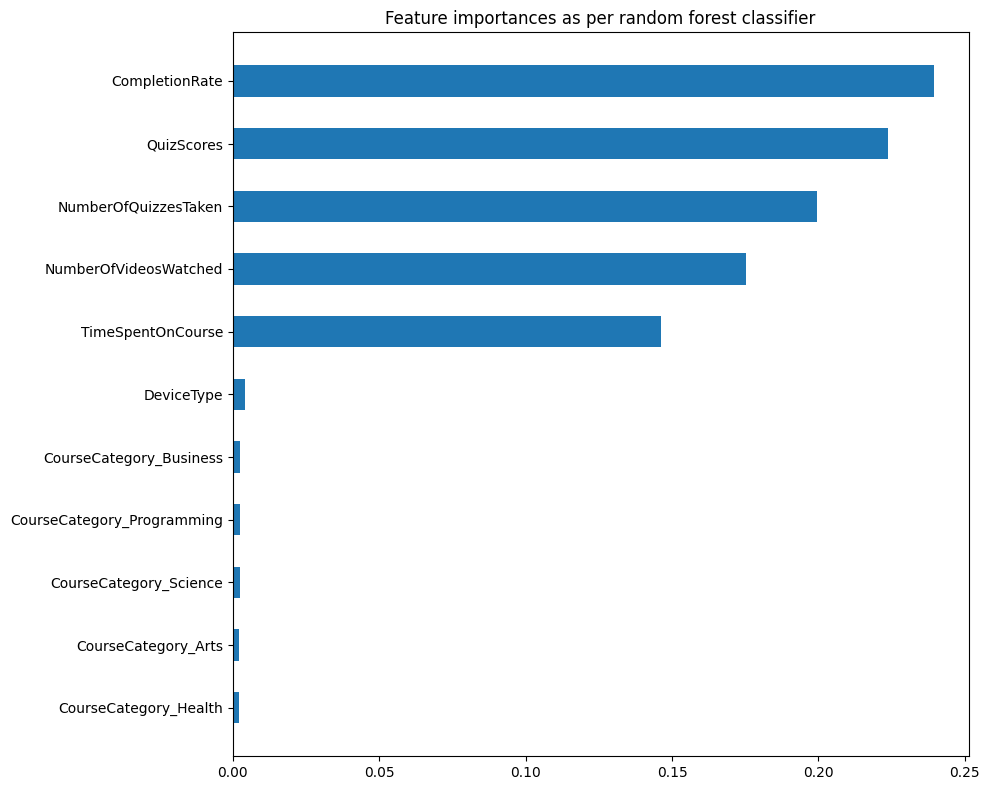

In [33]:
best_estimator = gs.best_estimator_
importances = best_estimator.feature_importances_
features = X_train.columns

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance')

plt.figure(figsize=(10, 8))

plt.barh(feature_importances['Feature'], feature_importances['Importance'], height=0.5)
plt.title('Feature importances as per random forest classifier')
plt.tight_layout()
plt.show()

As presumed, the course category and device type play an insignificant role in predicting the target variable. Final model is a random forest with 200 estimators and max tree depth of 10.